# **Weather Data Analysis for Irish Locations**

## **1. Introduction**


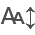

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itables import init_notebook_mode, show
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# Enable interactive mode for all DataFrames
init_notebook_mode(all_interactive=True)

[Reference: Pandas DataFrames as interactive HTML DataTables](https://marc-wouts.medium.com/pandas-dataframes-as-interactive-html-datatables-9737c7266abf)<br/>

---

## **2. Data Sources and File Paths**

In [220]:
# File paths and corresponding locations
file_paths = [
    'data/cork_airport.csv',
    'data/dublin_airport.csv',
    'data/knock_airport.csv',
    'data/malin_head.csv',
    'data/mullingar.csv'
]
locations = ['Cork', 'Dublin', 'Knock', 'Malin Head', 'Mullingar']

---

## **3. Data Loading and Preparation**

In [221]:
# Load each file and add the 'Location' column
cork_data = pd.read_csv(file_paths[0], skiprows=19) 
cork_data['Location'] = 'Cork'

dublin_data = pd.read_csv(file_paths[1], skiprows=19)
dublin_data['Location'] = 'Dublin'

knock_data = pd.read_csv(file_paths[2], skiprows=19)
knock_data['Location'] = 'Knock'

malin_data = pd.read_csv(file_paths[3], skiprows=19)
malin_data['Location'] = 'Malin Head'

mullingar_data = pd.read_csv(file_paths[4], skiprows=19)
mullingar_data['Location'] = 'Mullingar'

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>

---


## **4. Consolidating Data**

### **Column Descriptions**

- **year**: Year  
- **month**: Month  
- **rain**: Precipitation Amount (mm)  
- **meant**: Mean Air Temperature (°C)  
- **maxtp**: Maximum Air Temperature (°C)  
- **mintp**: Minimum Air Temperature (°C)  
- **mnmax**: Mean Maximum Temperature (°C)  
- **mnmin**: Mean Minimum Temperature (°C)  
- **gmin**: Grass Minimum Temperature (°C)  
- **wdsp**: Mean Wind Speed (knot)  
- **mxgt**: Highest Gust (knot)  
- **sun**: Sunshine Duration (hours)  


In [222]:

# Concatenate all DataFrames
all_data = pd.concat([cork_data, dublin_data, knock_data, malin_data, mullingar_data], ignore_index=True)

# Save the consolidated data to an SQLite database
conn = sqlite3.connect('data/weather_data.db')
all_data.to_sql('consolidated_weather', conn, if_exists='replace', index=False)

# Confirm the data was stored correctly
print("Preview of consolidated data in SQLite:")
print(pd.read_sql_query("SELECT * FROM consolidated_weather LIMIT 5", conn))


Preview of consolidated data in SQLite:
   year  month  meant maxtp mintp  mnmax  mnmin  rain  gmin  wdsp maxgt  \
0  1962      1    5.5  11.6  -3.8    8.2    2.7        -6.3  12.8    70   
1  1962      2    5.3  12.3  -2.7    7.9    2.7        -4.4  13.6    57   
2  1962      3    4.2  12.2  -5.4    7.5    0.9        -7.2  10.3    63   
3  1962      4    7.7  18.8   0.6   11.2    4.1  68.6  -1.3  11.7    62   
4  1962      5    9.7  16.1   2.3   13.3    6.2  80.7  -0.7  12.0    45   

     sun Location  
0            Cork  
1            Cork  
2            Cork  
3  201.1     Cork  
4  216.5     Cork  


[Reference: pandas.concat() function in Python](https://www.geeksforgeeks.org/pandas-concat-function-in-python/)<br/>
[Reference: How to write Pandas dataframe to sqlite with Index](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index)<br/>
[Reference: Accessing SQLite Databases Using Python and Pandas](https://datacarpentry.github.io/python-ecology-lesson/instructor/09-working-with-sql.html)<br/>
[Reference: Pandas Read SQL Query or Table with Examples](https://sparkbyexamples.com/pandas/pandas-read-sql-query-or-table/)<br/>
[Reference: MySQL LIMIT Clause](https://www.w3schools.com/mysql/mysql_limit.asp)<br/>

In [223]:

# Query to filter data for year >= 2000 and month >= 1
query = """
SELECT * 
FROM consolidated_weather
WHERE year >= 1997 AND month >= 1
"""
analysis_weather_records = pd.read_sql_query(query, conn)

# Confirm the filtered data
print("Filtered data preview:")
print(analysis_weather_records.head())



Filtered data preview:
   year  month  meant maxtp mintp  mnmax  mnmin   rain  gmin  wdsp maxgt  \
0  1997      1    4.7  10.5  -4.4    6.3    3.2   57.4  -7.2   9.4    33   
1  1997      2    6.7  12.3   1.0    9.5    3.9  159.3  -4.4  15.5    59   
2  1997      3    8.2  15.5   0.3   11.3    5.1   31.4  -6.3   9.9    50   
3  1997      4    9.9  17.1   1.6   13.5    6.2   48.0  -7.0   7.6    40   
4  1997      5   11.2  21.7   0.2   14.9    7.5   66.1  -2.6   9.5    42   

     sun Location  
0   31.2     Cork  
1   74.7     Cork  
2  112.9     Cork  
3  164.1     Cork  
4  235.9     Cork  


[Reference: The SQL WHERE Clause](https://www.w3schools.com/sql/sql_where.asp)<br/>
[Reference: MySQL AND, OR and NOT Operators](https://www.w3schools.com/mysql/mysql_and_or.asp)<br/>

----

## **6. Handling Missing Values**

In [224]:

# Replace blank fields and '-' with NaN in the filtered data
analysis_weather_records.replace([r'^\s*$'], np.nan, regex=True, inplace=True)

# Count and display missing values grouped by location
missing_values = analysis_weather_records.isnull().groupby(analysis_weather_records['Location']).sum()
print("Missing values by column and location:")
print(missing_values)

Missing values by column and location:
            year  month  meant  maxtp  mintp  mnmax  mnmin  rain  gmin  wdsp  \
Location                                                                       
Cork           0      0      0      0      0      0      0     0     0     0   
Dublin         0      0      0      0      0      0      0     0     1     0   
Knock          0      0      0      0      0      0      0     0     0     0   
Malin Head     0      0      0      0      0      0      0     0     0     1   
Mullingar      0      0      0      0      0      0      0     0     1     2   

            maxgt  sun  Location  
Location                          
Cork            0    0         0  
Dublin          0    0         0  
Knock           3   55         0  
Malin Head      0  166         0  
Mullingar       4  214         0  



[Reference: Replace values in Pandas dataframe using regex](https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/)<br/>
[Reference: Pandas: How to Replace Zero with NaN](https://www.statology.org/pandas-replace-0-with-nan/)<br/>
[Reference: A Guide to R Regular Expressions](https://www.datacamp.com/tutorial/regex-r-regular-expressions-guide) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: pd.NA vs np.nan for pandas](https://stackoverflow.com/questions/60115806/pd-na-vs-np-nan-for-pandas)<br/>



### **Overview of Missing Data**

- **Data Collection Gaps for `sun`**:
  - No data recorded in **Mullingar** since January 2007.
  - No data recorded in **Malin Head** since January 2011.
  - No data recorded in **Knock** since January 2020.

- **Specific Missing Values**:
  - **Dublin**: 1 missing `gmin` value.
  - **Mullingar**: 1 missing `gmin` value.
  - **Malin Head**: 1 missing `wdsp` value.

**Exclusions from Analysis**:
  - The `sun` and `gmin` columns will be excluded from the analysis as they are not relevant to the goals of this project.
  - One missing `wdsp` value will be dropped, as it is negligible in the overall dataset.


In [225]:
# Display the data types of all columns to verify they are correctly formatted for analysis
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp        object
mintp        object
mnmax       float64
mnmin       float64
rain         object
gmin         object
wdsp         object
maxgt        object
sun          object
Location     object
dtype: object


In [226]:
# Convert selected columns to numeric data types, coercing invalid entries to NaN for cleaning
columns_to_convert = ['maxtp', 'mintp', 'rain', 'gmin', 'wdsp', 'maxgt', 'sun']
for col in columns_to_convert:
    analysis_weather_records[col] = pd.to_numeric(analysis_weather_records[col], errors='coerce')

[Reference: pandas: to_numeric for multiple columns](https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns)<br/>

In [227]:
# Drop rows with missing 'wdsp' values
analysis_weather_records.dropna(subset=['wdsp'], inplace=True)

In [228]:
# Check the data types of all columns after conversion to ensure they are now correctly formatted
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp       float64
mintp       float64
mnmax       float64
mnmin       float64
rain        float64
gmin        float64
wdsp        float64
maxgt       float64
sun         float64
Location     object
dtype: object


[Reference: Pandas: How to Use dropna() with Specific Columns](https://www.statology.org/pandas-dropna-specific-column/)<br/>

---

## **7. Monthly Wind Speed Over Time per Location**

### **Line plot with markers showing the monthly mean wind speed for each location.**

In [229]:

# Extract relevant columns and create a copy to avoid modifying the original DataFrame
monthly_windspeed_data = analysis_weather_records[['Location', 'year', 'month', 'wdsp']].copy()

# Add a 'date' column and convert to datetime
monthly_windspeed_data['date'] = pd.to_datetime(
    monthly_windspeed_data[['year', 'month']].assign(day=1)
)

# Create subplots for each location
locations = monthly_windspeed_data['Location'].unique()
fig = make_subplots(
    rows=len(locations), cols=1, shared_xaxes=True,
    subplot_titles=[f"Average Windspeed - {loc}" for loc in locations]
)

# Plot wind speed trends for each location
for i, location in enumerate(locations):
    fig.add_trace(
        go.Scatter(
            x=monthly_windspeed_data[monthly_windspeed_data['Location'] == location]['date'],
            y=monthly_windspeed_data[monthly_windspeed_data['Location'] == location]['wdsp'],
            mode='lines+markers',
            name=location
        ),
        row=i + 1, col=1
    )

# Configure figure layout and shared axis settings
fig.update_layout(
    height=300 * len(locations),
    
    template="plotly_white",
    showlegend=False
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Average Windspeed (knots)")

# Render the final plot
fig.show()






[Reference: Plotly- Subplots in Python](https://plotly.com/python/subplots/?utm_source=chatgpt.com)<br/>
[Reference:Plotly- Scatter Plots in Python ](https://plotly.com/python/line-and-scatter/)<br/>
[Reference:Plotly- Python Figure Reference: layout ](https://plotly.com/python/reference/layout/)<br/>
[Reference:Plotly-Python Figure Reference: layout.xaxis ](https://plotly.com/python/reference/layout/xaxis/)<br/>
[Reference:Python Figure Reference: layout.yaxis ](https://plotly.com/python/reference/layout/yaxis/#:~:text=Python%20Figure%20Reference%3A%20layout.,yaxis&text=Type%3A%20dict%20containing%20one%20or%20more%20of%20the%20keys%20listed%20below.&text=If%20set%20to%20an%20opposite,the%20corresponding%20opposite%2Dletter%20axis.)<br/>
[Reference: Pandas DataFrame copy() Method](https://www.w3schools.com/python/pandas/ref_df_copy.asp)<br/>
[Reference: Pandas DataFrame assign() Method | Create new Columns in DataFrame](https://www.geeksforgeeks.org/pandas-dataframe-assign/)<br/>
[Reference: How to Specify Format in pandas.to_datetime](https://www.statology.org/pandas-to-datetime-format/) <br/>
[Reference: The Basics of the Python Enumerate() Function](https://blog.hubspot.com/website/python-enumerate)<br/>

### **Monthly Windspeed Analysis by Location**

1. **Malin Head**:  
   - **Highest**: 22.9 knots (Feb 1997), **Lowest**: 7.8 knots (Jul 2024).  
   - Largest seasonal variance with frequent winter spikes.  

2. **Knock**:  
   - **Highest**: 15 knots (Feb 1997), **Lowest**: 6.1 knots (Jul 2024).  
   - Steady overall with occasional large winter spikes.  

3. **Cork**:  
   - **Highest**: 15 knots (Feb 1997), **Lowest**: 6.1 knots (Sep 2014, Jul 2021).  
   - Steady with winter spikes every few years.  

4. **Dublin**:  
   - **Highest**: 16.4 knots (Feb 1997), **Lowest**: 6.5 knots (Sep 2014).  
   - Slight downward trend since 2018; winter spikes present.  

**Key Insight**: All locations recorded their highest windspeed in **February 1997**, indicating a significant weather event.🚀

----

## **8. Seasonal Windspeed by Location**

In [230]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add a 'season' column to the DataFrame
monthly_windspeed_data['Season'] = monthly_windspeed_data['month'].apply(get_season)

# Group by Location and Season, and calculate the mean windspeed
seasonal_windspeed_summary = (
    monthly_windspeed_data
    .groupby(['Location', 'Season'])['wdsp']
    .mean()
    .reset_index()
    .sort_values(by=['Location', 'Season'])
)
# Rename the columns for clarity
seasonal_windspeed_summary.columns = ['Location', 'Season', 'Average Windspeed']

# Display the summary table
display(seasonal_windspeed_summary)



Location  Season  Average Windspeed
0         Cork  Autumn           9.506024
1         Cork  Spring           9.834524
2         Cork  Summer           8.653571
3         Cork  Winter          10.816867
4       Dublin  Autumn          10.240964
5       Dublin  Spring          10.194048
6       Dublin  Summer           9.055952
7       Dublin  Winter          11.739759
8        Knock  Autumn           9.246988
9        Knock  Spring           9.547619
10       Knock  Summer           8.422619
11       Knock  Winter          10.595181
12  Malin Head  Autumn          15.578313
13  Malin Head  Spring          14.247619
14  Malin Head  Summer          12.110843
15  Malin Head  Winter          17.514458
16   Mullingar  Autumn           6.259036
17   Mullingar  Spring           6.591667
18   Mullingar  Summer           5.586585
19   Mullingar  Winter           7.226506

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>

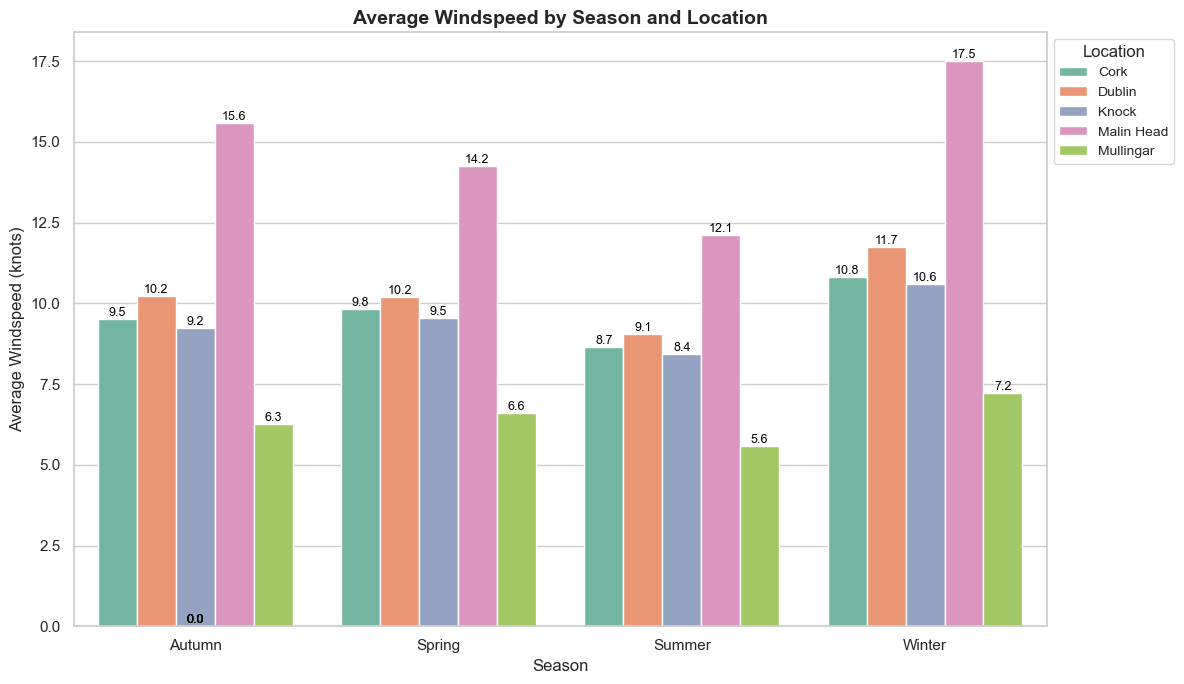

In [231]:
# Select the correct number of colors
num_locations = seasonal_windspeed_summary['Location'].nunique()
palette = sns.color_palette("Set2", n_colors=num_locations)  # Use only required colors

# Updated bar plot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=seasonal_windspeed_summary,
    x='Season',
    y='Average Windspeed',
    hue='Location',
    palette=palette
)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')

# Labels and legend
plt.title("Average Windspeed by Season and Location", fontsize=14, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Windspeed (knots)", fontsize=12)
plt.legend(title="Location", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.show()


[Reference: Grouped Barplot using Seaborn](https://python-graph-gallery.com/grouped-barplot/)<br/>
[Reference: Annotate bars with values on Pandas bar plots](https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots)<br/>
[Reference: How To Annotate Bars in Barplot with Matplotlib in Python?](https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)<br/>

### Seasonal Windspeed by Location Analysis

- **Winter** offers the best wind energy potential, while **summer** has the lowest output across all locations.
- **Malin Head** is the most suitable site, with consistently strong winds year-round. 
- **Mullingar** is the least favorable due to low windspeeds, especially in summer.
- Coastal areas (e.g., Malin Head, Dublin) outperform inland regions, emphasizing location importance.
- Seasonal variability necessitates planning for reduced summer output and complementary energy sources.

---

## **9. Yearly windspeed summary by location**

In [232]:
# Group by Location and Year, and calculate summary statistics
yearly_windspeed_summary = (
    monthly_windspeed_data
    .groupby(['Location', 'year'])['wdsp']
    .agg(['mean', 'median', 'var'])
    .reset_index()
)

# Rename the columns for clarity
yearly_windspeed_summary.columns = ['Location', 'Year', 'Mean Windspeed', 'Median Windspeed', 'Variance']


# Display table
show(yearly_windspeed_summary)


[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>

Wind turbines **start operating** at **Beaufort Force 3**, reach **maximum power** at **Force 5**, and **shut down** at Storm **Force 10** to prevent damage
<br/>
[Source: Irish Wind Energy Association](http://www.iwea.ie/technicalfaqs#:~:text=Turbines%20reach%20maximum%20power%20output,prevent%20excessive%20wear%20and%20tear.)
<br/>
| Beaufort Rating | Wind Speed (Knots) |
|-----------------|--------------------|
| 0               | < 1                |
| 1               | 1–3                |
| 2               | 4–6                |
| 3               | 7–10               |
| 4               | 11–16              |
| 5               | 17–21              |


[Source: Met Eireann](https://www.met.ie/cms/assets/uploads/2022/09/Beaufort-scale-for-land.png)
<br/>

In [233]:
# Group by Location and calculate summary statistics
location_summary = yearly_windspeed_summary.groupby('Location').agg(
    Mean_Windspeed_Min=('Mean Windspeed', 'min'),
    Mean_Windspeed_Max=('Mean Windspeed', 'max'),
    Variance_Avg=('Variance', 'mean')
).reset_index()

def classify_windspeed(row):
    
    max_wind_knots = row['Mean_Windspeed_Max']
    min_wind_knots = row['Mean_Windspeed_Min']
    wind_variance = row['Variance_Avg']
    
    # Strong winds: Beaufort 5 and above (17+ knots)
    if max_wind_knots >= 17:
        if wind_variance < 3:
            return "Strong and stable winds, turbines reach maximum power."
        else:
            return "Strong but variable winds, turbines reach maximum power."
    
    # Moderate winds: Beaufort 4 (11–16 knots)
    elif max_wind_knots >= 11:
        if min_wind_knots >= 7 and wind_variance < 3:
            return "Moderate and stable winds, turbines operate efficiently."
        else:
            return "Moderate but variable winds, suitable for energy generation."
    
    # Gentle winds: Beaufort 3 (7–10 knots)
    elif max_wind_knots >= 7:
        return "Gentle winds, turbines are operational but efficiency is limited."
    
    # Low winds: Below Beaufort 3 (< 7 knots)
    else:
        return "Low winds, turbines are not operational."


# Apply the updated classification
location_summary['Analysis'] = location_summary.apply(classify_windspeed, axis=1)

# Display the summarized table
display(location_summary)


Location  Mean_Windspeed_Min  Mean_Windspeed_Max  Variance_Avg  \
0        Cork            8.975000           10.366667      2.249477   
1      Dublin            8.641667           11.541667      3.134079   
2       Knock            8.358333           10.200000      2.251128   
3  Malin Head           12.933333           16.525000      8.780041   
4   Mullingar            5.208333            7.490909      1.296408   

                                            Analysis  
0  Gentle winds, turbines are operational but eff...  
1  Moderate but variable winds, suitable for ener...  
2  Gentle winds, turbines are operational but eff...  
3  Moderate but variable winds, suitable for ener...  
4  Gentle winds, turbines are operational but eff...

[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>
[Reference: Pandas Apply: 12 Ways to Apply a Function to Each Row in a DataFrame](https://www.ml4devs.com/articles/pandas-dataframe-apply-function-iterate-over-rows/)
<br/>

### **Yearly Average Windspeed Summary**

- **Cork**: Moderate windspeeds (mean: ~9–10.3 m/s) with consistent variance, suitable for stable wind conditions.
- **Dublin**: Higher windspeeds (~9–11.5 m/s) but variable, with peaks in 2008 and high turbulence in 2011.
- **Knock**: Lower windspeeds (~8.3–10.2 m/s) with moderate variance, indicating steady but less intense wind conditions.
- **Malin Head**: Strongest windspeeds (~13–16.5 m/s), high variability, ideal for wind energy projects.
- **Mullingar**: Lowest windspeeds (~5–7.5 m/s), minimal variance, less viable for wind energy.

**Coastal locations (e.g., Malin Head, Dublin)** show high wind potential, while **inland locations (e.g., Mullingar)** are more stable but less intense.

---

## **10.Predicting Future Wind Trends**

### Linear regression

In [234]:
# Create a 'date' column by combining 'year' and 'month', setting the day to 1
monthly_windspeed_data['date'] = pd.to_datetime(monthly_windspeed_data[['year', 'month']].assign(day=1)
)

# Convert 'date' to a numeric format for linear regression model
monthly_windspeed_data['date_numeric'] = monthly_windspeed_data['date'].map(pd.Timestamp.toordinal)

# Get unique locations from the dataset
locations = monthly_windspeed_data['Location'].unique()


In [235]:
# Dictionary to store predictions
all_predictions = {}

# Iterate through locations
for location in locations:
    # Filter data for the current location
    location_data = monthly_windspeed_data[monthly_windspeed_data['Location'] == location]

    # Ensure data is not empty
    if location_data.empty:
        print(f"No data for location: {location}")
        continue

    # Define features and target
    X = location_data[['date_numeric']]
    y = location_data['wdsp']

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Generate future monthly dates starting from the first day of the next month, for the next 120 months
    future_dates = pd.date_range(
        start=location_data['date'].max() + pd.offsets.MonthBegin(1), 
        periods=120, 
        freq='MS'
    )

    # Create a DataFrame to store the future dates
    future_data = pd.DataFrame({'date': future_dates})

    # Convert future dates to numeric format for regression model
    future_data['date_numeric'] = future_data['date'].map(pd.Timestamp.toordinal)

    # Predict future wind speeds using the trained model
    future_data['predicted_wdsp'] = model.predict(future_data[['date_numeric']])

    # Store predictions for the current location
    all_predictions[location] = future_data

# Print the predictions for all locations
print(all_predictions)



{'Cork':           date  date_numeric  predicted_wdsp
0   2024-11-01        739191        9.640174
1   2024-12-01        739221        9.639822
2   2025-01-01        739252        9.639458
3   2025-02-01        739283        9.639094
4   2025-03-01        739311        9.638766
..         ...           ...             ...
115 2034-06-01        742690        9.599122
116 2034-07-01        742720        9.598770
117 2034-08-01        742751        9.598406
118 2034-09-01        742782        9.598043
119 2034-10-01        742812        9.597691

[120 rows x 3 columns], 'Dublin':           date  date_numeric  predicted_wdsp
0   2024-11-01        739191        9.692474
1   2024-12-01        739221        9.688878
2   2025-01-01        739252        9.685163
3   2025-02-01        739283        9.681448
4   2025-03-01        739311        9.678092
..         ...           ...             ...
115 2034-06-01        742690        9.273135
116 2034-07-01        742720        9.269539
117 2034-08

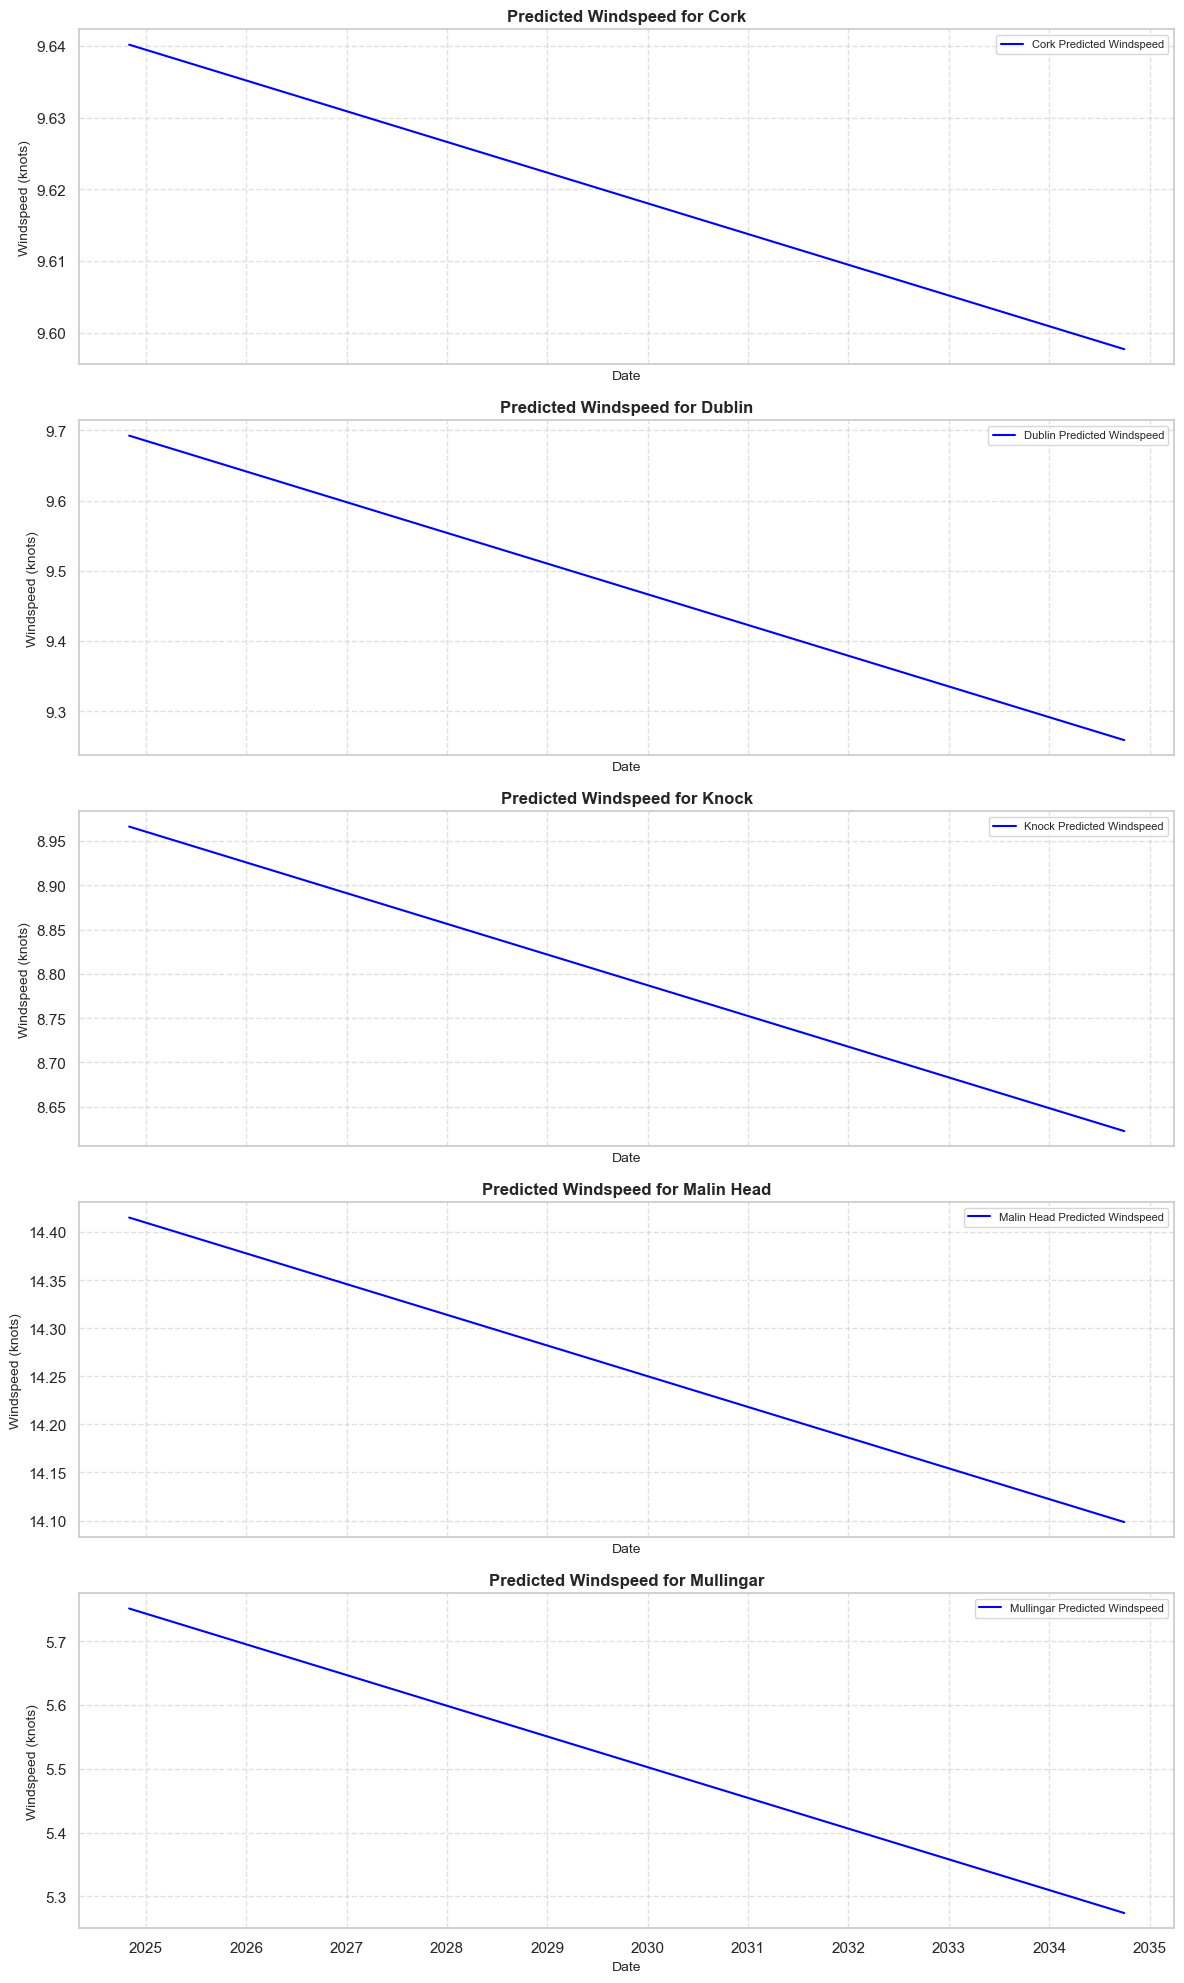

In [236]:

# Number of locations
num_locations = len(all_predictions)

# Create subplots: 1 row for each location
fig, axes = plt.subplots(num_locations, 1, figsize=(12, 4 * num_locations), sharex=True)


# Iterate through locations and plot each on its own subplot
for ax, (location, df) in zip(axes, all_predictions.items()):
    ax.plot(df['date'], df['predicted_wdsp'], label=f'{location} Predicted Windspeed', color='blue')
    ax.set_title(f'Predicted Windspeed for {location}', fontsize=12, weight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Windspeed (knots)', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



---

In [237]:
# Close the SQLite connection
conn.close()
